In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


In [2]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df

df = load_data("train.csv")

In [3]:
df_train = load_data("test_data.csv")


In [4]:
def clean(df):


    df = df.drop(df[df['station'].isin(["leicestershire",'humberside', 'lancashire','metropolitan','west-midlands'])].index)
    
    df['Part of a policing operation'] = df['Part of a policing operation'].fillna(False)
    df['Part of a policing operation'] = df['Part of a policing operation'].astype(bool)

    df['Outcome linked to object of search'] = df['Outcome linked to object of search'].fillna(False)

    df['Legislation'] = df['Legislation'].fillna('unknown')
    
    df.loc[df['Outcome'] == 'A no further action disposal', 'Outcome linked to object of search'] = False
    
    success_outcomes = ['Community resolution', 'Khat or Cannabis warning', 'Caution (simple or conditional)', 
                    'Arrest', 'Penalty Notice for Disorder', 'Summons / charged by post', 
                    'Suspect arrested', 'Suspect summoned to court']

    # create a new column called "success" with 1 if the outcome is in the list of successful outcomes, 0 otherwise
    df['success'] = df.apply(lambda x: True if x['Outcome'] in success_outcomes and x['Outcome linked to object of search'] == True else False, axis=1)


    #df=df.dropna()
    return df

df_new = clean(df)

In [5]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['Date'] = pd.to_datetime(X['Date'])
        X['Hour'] = X['Date'].dt.hour
        X['Month'] = X['Date'].dt.month
        X['Day'] = X['Date'].dt.day
        X['DayOfWeek'] = X['Date'].dt.weekday
        X=X.drop(columns = "Date", axis=1)
        
        return X[['Hour','Month', 'Day', 'DayOfWeek']]

    def get_feature_names_out(self):
        return [('Date', 'Hour'), ('Date', 'Month'), ('Date', 'Day'),('Date', 'DayOfWeek')]


In [6]:
from lightgbm import LGBMClassifier

features = ['Part of a policing operation','Legislation', 'Object of search','Date',"Age range","Gender",'station','Officer-defined ethnicity']
target = 'success'

X_train = df_new[features]
y_train =  df_new[target]


categorical_columns = ['Legislation', 'Object of search','Part of a policing operation','Date',"Age range","Gender",'Officer-defined ethnicity','station']
feat_columns = ['Date']

categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ])

preprocessor = ColumnTransformer(
    transformers=[
       ('date_transformer', DateTransformer(), feat_columns),
        ('categorical_transformers', categorical_transformer, categorical_columns),
    ])


preprocessor.fit(X_train)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ("classifer",LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42))
                           #("classifer",GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42))
                           #("Classifier", LogisticRegression(n_jobs=-1))
                           #("classifier", RandomForestClassifier(n_estimators=20, max_depth=3, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1))
                            #("classifier", LGBMClassifier(n_estimators=100, max_depth = 3,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1))
                           
                           
                
                            ])

# Fit model on training data
pipeline.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('date_transformer',
                                                  DateTransformer(), ['Date']),
                                                 ('categorical_transformers',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Legislation',
                                                   'Object of search',
                                                   'Part of a policing '
                                                   'operation',
                                                   'Date', 'Age range',
                                                   'Gender',
                                                   'Officer-defined ethnicity',
                                                   'station'])])),
                ('classifer',
                 LogisticRegression(C=1, class_weight='balanced', n_jobs=-1,
                                    random_state=42))])

In [7]:
X_test = df_train[features]
y_test = df_train['Outcome']


In [8]:

from sklearn.metrics import confusion_matrix
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Get predicted probabilities for positive class


best_threshold = 0
best_false_false_rate = 0
recall_range = (0.90, 1)

for threshold in range(0, 100):
    threshold /= 100
    y_pred = (y_pred_proba > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    false_false_rate = tn / (tn + fp)
    recall = tp / (tp + fn)
    if false_false_rate > best_false_false_rate and recall_range[0] <= recall <= recall_range[1]:
        best_threshold = threshold
        best_false_false_rate = false_false_rate

print(f'Best threshold: {best_threshold}')

Best threshold: 0.39


F1 score: 0.3758628367846805
Recall score: 0.9547511312217195
ROC score: 0.536846228876166
Precision score: 0.23398946492930414


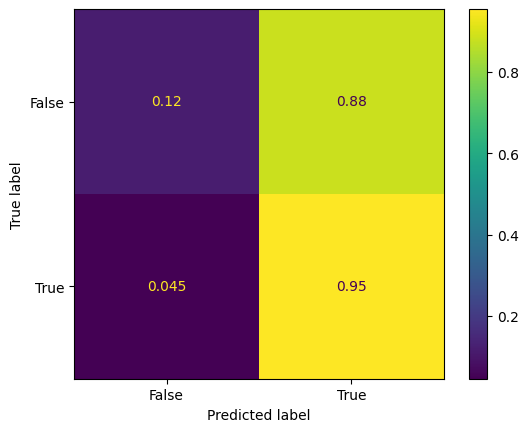

In [10]:

threshold = 0.35
y_pred = (y_pred_proba > threshold).astype(int)

prediction_value = (y_pred_proba > threshold)

# Print f1 score, recall score, and precision score
print('F1 score:', f1_score(y_test, y_pred))
print('Recall score:', recall_score(y_test, y_pred))
print("ROC score:", roc_auc_score(y_test, y_pred))
print('Precision score:', precision_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipeline.classes_)
disp.plot()


In [11]:
df_train['Predicted outcome']=prediction_value

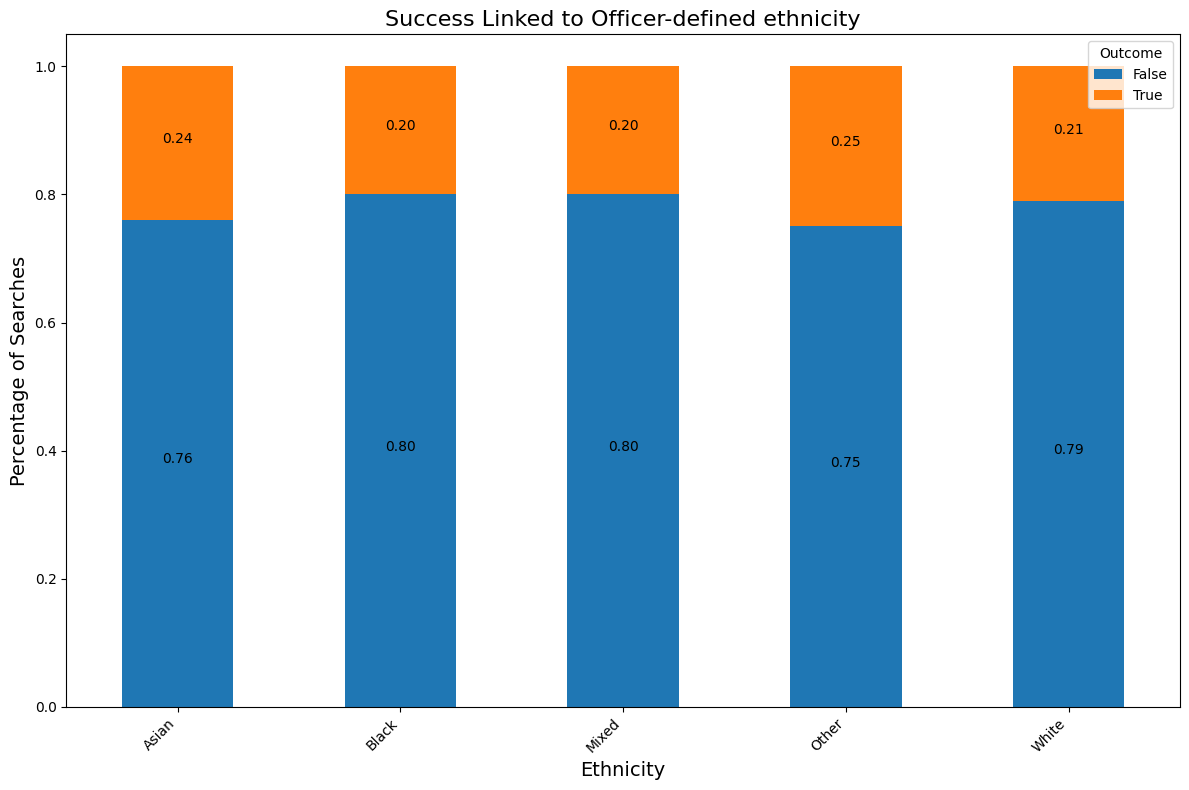

In [12]:
data = df_train.copy()

threshold = 15

data = data.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= threshold )

data['success'] = data.apply(lambda x: True if x['Outcome']== True  and x['Predicted outcome'] == True else False, axis=1)

# Subset the dataframe to only include the columns of interest
ethnicity_outcome_df = data[['Officer-defined ethnicity', 'success']]

# Group the dataframe by ethnicity and outcome and calculate the count
ethnicity_outcome_count = ethnicity_outcome_df.groupby(['Officer-defined ethnicity', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity as rows, outcome as columns, and count as values
ethnicity_outcome_pivot = ethnicity_outcome_count.pivot(index='Officer-defined ethnicity', columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity
ethnicity_outcome_pct = ethnicity_outcome_pivot.div(ethnicity_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Success Linked to Officer-defined ethnicity', fontsize=16)
ax.set_xlabel('Ethnicity', fontsize=14)
ax.set_ylabel('Percentage of Searches', fontsize=14)
ax.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')

# Add text annotations with the raw number on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}', (x + width/2, y + height/2), ha='center')
plt.tight_layout()
plt.show()


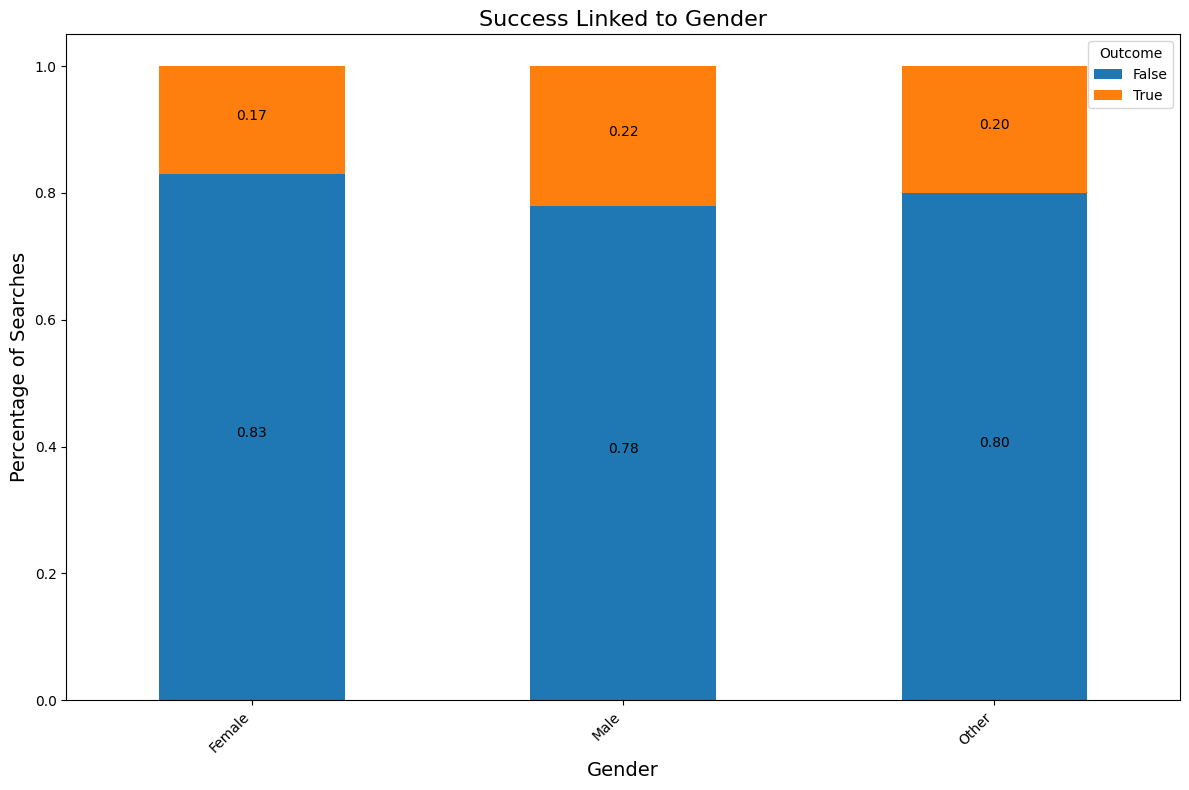

In [13]:
data = df_train.copy()

threshold = 15

data = data.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= threshold )

data['success'] = data.apply(lambda x: True if x['Outcome']== True  and x['Predicted outcome'] == True else False, axis=1)


# Subset the dataframe to only include the columns of interest
ethnicity_outcome_df = data[['Gender', 'success']]

# Group the dataframe by ethnicity and outcome and calculate the count
ethnicity_outcome_count = ethnicity_outcome_df.groupby(['Gender', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity as rows, outcome as columns, and count as values
ethnicity_outcome_pivot = ethnicity_outcome_count.pivot(index='Gender', columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity
ethnicity_outcome_pct = ethnicity_outcome_pivot.div(ethnicity_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Success Linked to Gender', fontsize=16)
ax.set_xlabel('Gender', fontsize=14)
ax.set_ylabel('Percentage of Searches', fontsize=14)
ax.legend(title='Outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')

# Add text annotations with the raw number on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}', (x + width/2, y + height/2), ha='center')
plt.tight_layout()
plt.show()

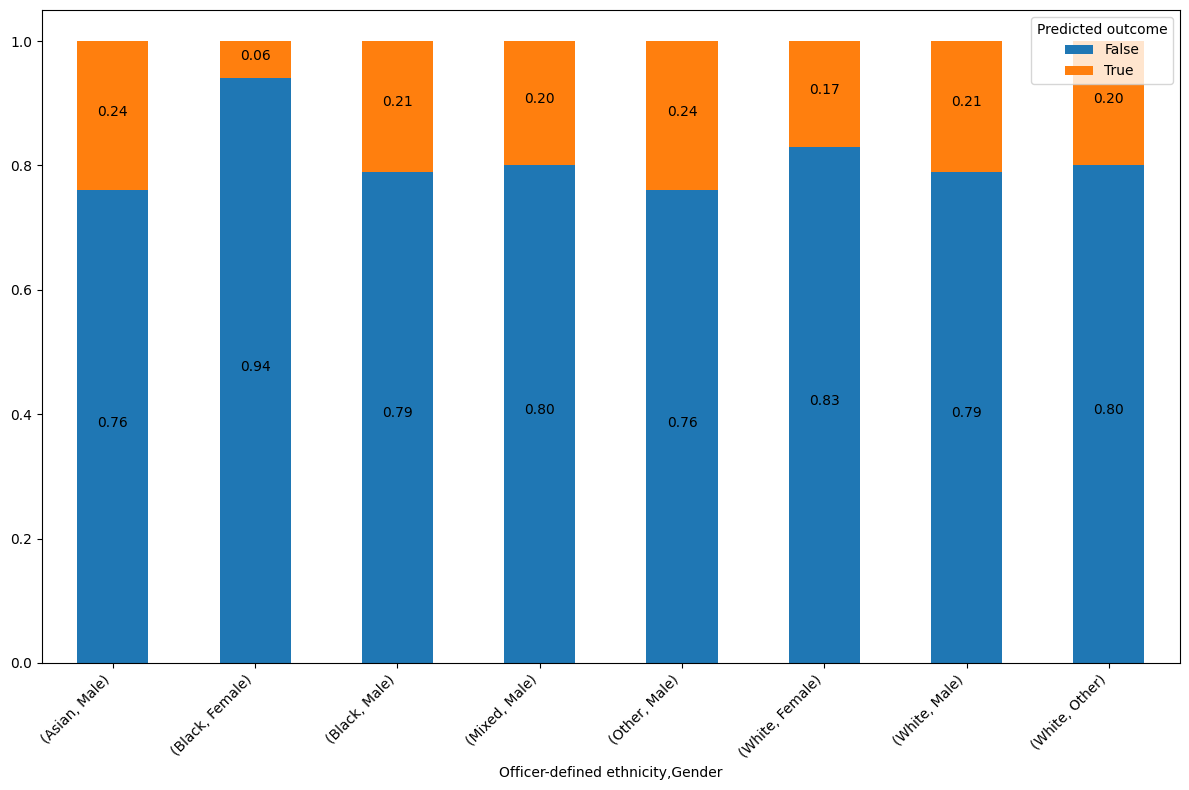

/home/francisco/.virtualenvs/slu01/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
data = df_train.copy()
threshold = 10

data = data.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= threshold )

data['success'] = data.apply(lambda x: True if x['Outcome']== True  and x['Predicted outcome'] == True else False, axis=1)


# Subset the dataframe to only include the columns of interest
ethnicity_gender_outcome_df = data[['Officer-defined ethnicity', 'Gender', 'success']]

# Group the dataframe by ethnicity, gender and outcome and calculate the count
ethnicity_gender_outcome_count = ethnicity_gender_outcome_df.groupby(['Officer-defined ethnicity', 'Gender', 'success']).size().reset_index(name='Count')

# Pivot the dataframe to have ethnicity and gender as rows, outcome as columns, and count as values
ethnicity_gender_outcome_pivot = ethnicity_gender_outcome_count.pivot_table(index=['Officer-defined ethnicity', 'Gender'], columns='success', values='Count').fillna(0)

# Calculate the percentage of outcomes for each ethnicity and gender
ethnicity_gender_outcome_pct = ethnicity_gender_outcome_pivot.div(ethnicity_gender_outcome_pivot.sum(axis=1), axis=0).round(2)

# Create a stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ethnicity_gender_outcome_pct.plot(kind='bar', stacked=True, ax=ax)
ax.legend(title='Predicted outcome', loc='upper right')
plt.xticks(rotation=45, ha='right')

# Add text annotations with the raw number on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2f}', (x + width/2, y + height/2), ha='center')

plt.tight_layout()
plt.show()

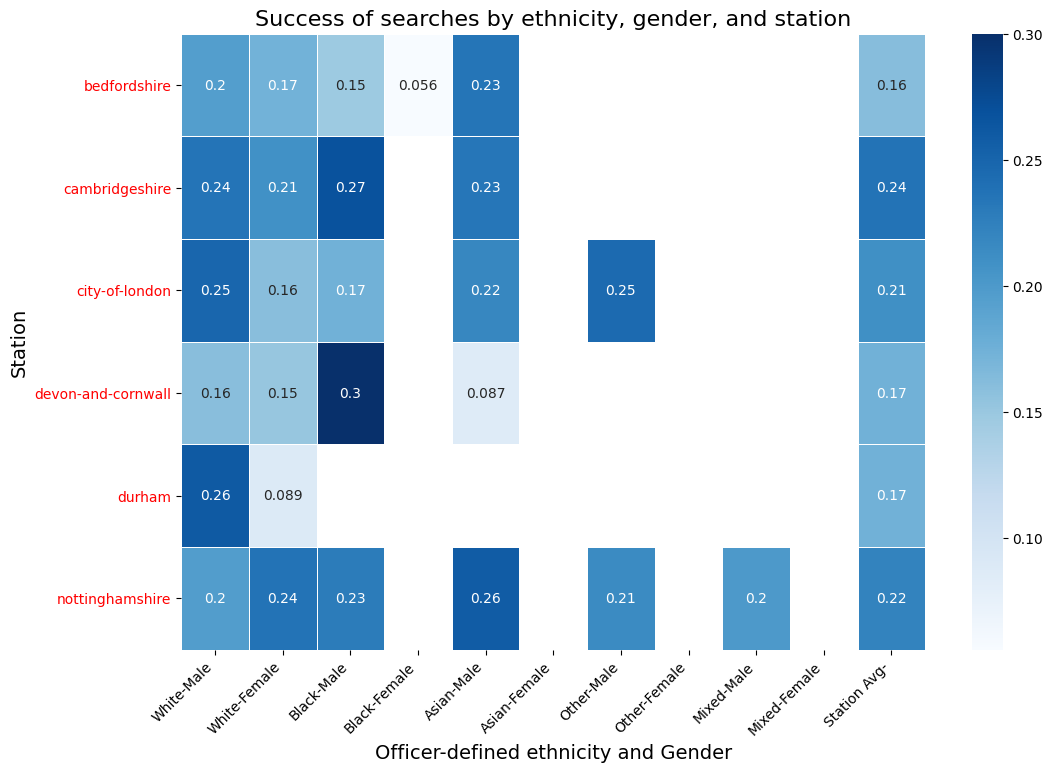

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to determine if a station is problematic
def is_problematic(row):
    threshold = 0.05
    return row.max() - row.min() > threshold

# Select relevant columns
data = df_train[['station', 'Officer-defined ethnicity', 'Predicted outcome', 'Gender','Outcome',"observation_id"]].copy()

threshold = 10
data = data.groupby(['station', 'Officer-defined ethnicity','Gender']).filter(lambda x : x['observation_id'].count() >= threshold )


data['success'] = data.apply(lambda x: True if (x['Outcome']== True  and x['Predicted outcome'] == True) else False, axis=1)


data['Officer-defined ethnicity'] = data['Officer-defined ethnicity'].astype(str)

# Pivot data
pivot_data = data.pivot_table(index='station', columns=['Officer-defined ethnicity', 'Gender'], 
                              values='success', aggfunc='mean')



# Reorder columns to show 'White' ethnicity first, then 'Female' gender
pivot_data = pivot_data.reindex(columns=pd.MultiIndex.from_product([['White', 'Black', 'Asian', 'Other','Mixed'], ['Male', 'Female']]))

# Calculate average success rate for each station
pivot_data['Station Avg'] = pivot_data.mean(axis=1)
# Create copy of pivot table to highlight problematic stations
data_test = pivot_data.copy()

# Convert categorical column to string column
data_test.columns = data_test.columns.map(str)

# Create new column with True/False values
data_test['problematic'] = data_test.apply(is_problematic, axis=1)

highlight_stations = data_test[data_test['problematic']].index.tolist()

# Create heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='Blues', linewidths=.5, ax=ax)

# Set plot title and axis labels
ax.set_title('Success of searches by ethnicity, gender, and station', fontsize=16)
ax.set_xlabel('Officer-defined ethnicity and Gender', fontsize=14)
ax.set_ylabel('Station', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

tick_labels = ax.get_yticklabels()
for label in tick_labels:
    if label.get_text() in highlight_stations:
        label.set_color('red')
    else:
        label.set_color('black')

plt.show()

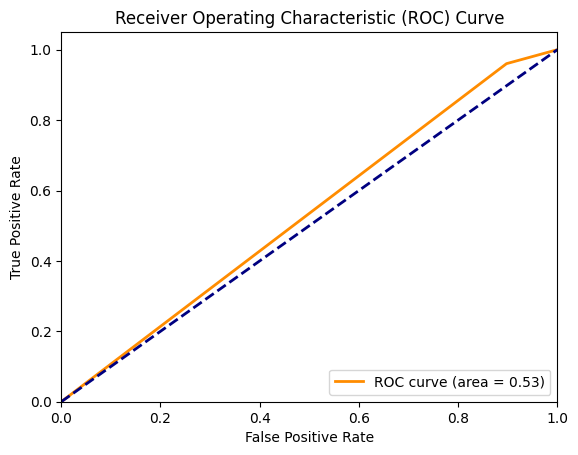

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true and y_pred are the true and predicted labels, respectively
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [94]:
df_train['Outcome'] = y_pred
df_train

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station,Outcome,Predicted outcome
0,eeb891e3-3913-4590-82a9-dc23c212dceb,Person search,2022-04-18T22:24:57+00:00,False,NaN,NaN,Male,10-17,Other,Police and Criminal Evidence Act 1984 (section 1),Articles for use in criminal damage,city-of-london,1,True
1,898d6606-c55b-4a54-9480-f967beaff1cf,Person and Vehicle search,2022-01-07T20:20:00+00:00,True,NaN,NaN,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,1,True
2,3ff08b3c-c1fc-4c9f-97fe-470cf3a61cef,Person search,2022-05-08T20:21:00+00:00,True,NaN,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,1,True
3,73d7c589-7605-42ab-9c5c-d0fbb897adb0,Person search,2022-02-12T01:43:00+00:00,False,54.525683,-1.556382,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,durham,0,False
4,1d276941-2dd7-4cc0-b14d-764ee8bcd966,Person search,2022-05-13T18:23:00+00:00,True,NaN,NaN,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,dec81b01-b351-4030-b419-6044c91cd895,Person search,2022-03-13T02:45:00+00:00,False,50.213930,-5.300091,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,devon-and-cornwall,0,False
4016,9c7e363f-26df-4b8a-92cf-b3cbf70827cc,Person search,2022-03-13T15:45:00+00:00,False,NaN,NaN,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire,0,False
4017,b08e103a-4f94-48c6-974f-1b746dde4ca0,Person and Vehicle search,2022-03-13T23:24:00+00:00,False,50.372266,-4.136544,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,0,False
4018,493b76ae-8e5e-498d-8a9d-68eeeb8d51de,Person and Vehicle search,2022-03-14T03:22:00+00:00,False,50.630731,-3.565678,Female,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,devon-and-cornwall,1,True


In [17]:
df_train1= df_train[['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Officer-defined ethnicity', 'Legislation', 'Object of search',
       'station']].copy()

In [20]:
# Set the base URL of your API
import requests
import pandas as pd
import time

APP_NAME = 'railcap-production.up.railway.app'
base_url = "https://{}/should_search/".format(APP_NAME)
# Test locally
#base_url = f"http://localhost:5000/should_search/"

# Define the columns to check for missing values
x=0
l=[]
for i, row in df_train1.iterrows():
    # Remove any columns with NaN values from the row
    row = row.dropna()

    # Convert the row to a dictionary
    row_dict = row.to_dict()
    print(row_dict)
    # Send a POST request to your API with the row data
    response = requests.post(base_url, json=row_dict)

    # Print the response status code and content for debugging purposes
    print(response.status_code)
    print(response.content)
    
    time.sleep(30)
    x+=1
    if x == 1000 :
        break

{'observation_id': 'eeb891e3-3913-4590-82a9-dc23c212dceb', 'Type': 'Person search', 'Date': '2022-04-18T22:24:57+00:00', 'Part of a policing operation': False, 'Gender': 'Male', 'Age range': '10-17', 'Officer-defined ethnicity': 'Other', 'Legislation': 'Police and Criminal Evidence Act 1984 (section 1)', 'Object of search': 'Articles for use in criminal damage', 'station': 'city-of-london'}
405
b'{\n  "error": "Observation ID: \\"eeb891e3-3913-4590-82a9-dc23c212dceb\\" already exists",\n  "outcome": false\n}\n'
{'observation_id': '898d6606-c55b-4a54-9480-f967beaff1cf', 'Type': 'Person and Vehicle search', 'Date': '2022-01-07T20:20:00+00:00', 'Part of a policing operation': True, 'Gender': 'Male', 'Age range': '25-34', 'Officer-defined ethnicity': 'White', 'Legislation': 'Misuse of Drugs Act 1971 (section 23)', 'Object of search': 'Controlled drugs', 'station': 'nottinghamshire'}
405
b'{\n  "error": "Observation ID: \\"898d6606-c55b-4a54-9480-f967beaff1cf\\" already exists",\n  "outcome

200
b'{\n  "outcome": false\n}\n'
{'observation_id': '06e5e365-15a8-465a-8092-eef6762a78d7', 'Type': 'Person search', 'Date': '2022-04-27T08:02:00+00:00', 'Part of a policing operation': False, 'Latitude': 54.630745, 'Longitude': -1.651373, 'Gender': 'Male', 'Age range': 'over 34', 'Officer-defined ethnicity': 'White', 'Legislation': 'Police and Criminal Evidence Act 1984 (section 1)', 'Object of search': 'Article for use in theft', 'station': 'durham'}
200
b'{\n  "outcome": true\n}\n'
{'observation_id': '89f0b741-dd82-4600-8b98-4c3230a0540d', 'Type': 'Person search', 'Date': '2022-03-09T05:33:02+00:00', 'Part of a policing operation': False, 'Gender': 'Male', 'Age range': 'over 34', 'Officer-defined ethnicity': 'White', 'Legislation': 'Misuse of Drugs Act 1971 (section 23)', 'Object of search': 'Controlled drugs', 'station': 'city-of-london'}
200
b'{\n  "outcome": true\n}\n'
{'observation_id': '1b553034-0b2b-435b-b614-ce0a6c8d5f83', 'Type': 'Person search', 'Date': '2022-01-01T01:05:0

200
b'{\n  "outcome": true\n}\n'
{'observation_id': '63e10559-6625-47ae-8cd6-1a3cafc45012', 'Type': 'Person and Vehicle search', 'Date': '2022-01-01T05:00:00+00:00', 'Part of a policing operation': False, 'Latitude': 52.005702, 'Longitude': -0.429307, 'Gender': 'Female', 'Age range': '25-34', 'Officer-defined ethnicity': 'Asian', 'Legislation': 'Misuse of Drugs Act 1971 (section 23)', 'Object of search': 'Controlled drugs', 'station': 'bedfordshire'}
200
b'{\n  "outcome": true\n}\n'
{'observation_id': '9e8783a9-8377-448f-8882-d4b2f352187a', 'Type': 'Person search', 'Date': '2022-01-01T05:16:47+00:00', 'Part of a policing operation': True, 'Latitude': 51.506255, 'Longitude': -0.074901, 'Gender': 'Male', 'Age range': '10-17', 'Officer-defined ethnicity': 'Asian', 'Legislation': 'Police and Criminal Evidence Act 1984 (section 1)', 'Object of search': 'Offensive weapons', 'station': 'city-of-london'}
200
b'{\n  "outcome": false\n}\n'
{'observation_id': '5f10c933-9c8b-4f9e-872c-c807b41a75c2

200
b'{\n  "outcome": true\n}\n'
{'observation_id': '06f89c2a-408f-4fc4-858b-a9563ff5b445', 'Type': 'Person search', 'Date': '2022-01-02T01:10:00+00:00', 'Part of a policing operation': False, 'Latitude': 50.128305, 'Longitude': -5.541647, 'Gender': 'Female', 'Age range': 'over 34', 'Officer-defined ethnicity': 'White', 'Legislation': 'Misuse of Drugs Act 1971 (section 23)', 'Object of search': 'Controlled drugs', 'station': 'devon-and-cornwall'}
200
b'{\n  "outcome": true\n}\n'
{'observation_id': 'c680822c-4619-460a-acc7-75c18f4f7bc2', 'Type': 'Person and Vehicle search', 'Date': '2022-01-02T01:30:00+00:00', 'Part of a policing operation': True, 'Latitude': 54.65702, 'Longitude': -1.676693, 'Gender': 'Male', 'Age range': '18-24', 'Officer-defined ethnicity': 'White', 'Legislation': 'Misuse of Drugs Act 1971 (section 23)', 'Object of search': 'Controlled drugs', 'station': 'durham'}
200
b'{\n  "outcome": true\n}\n'
{'observation_id': '2c76c3fb-7683-4e7d-b1a0-b31e8b0a125e', 'Type': 'Per

KeyboardInterrupt: 

In [ ]:
df_train['outcome']=df_train['Outcome']
df_train2= df_train[['observation_id','outcome']].copy()
APP_NAME = 'railcap-production.up.railway.app'
base_url = "https://{}/should_search/".format(APP_NAME)
# Test locally
#base_url = f"http://localhost:5000/search_result/"

# Define the columns to check for missing values
x=0
l=[]
for i, row in df_train2.iterrows():
    # Remove any columns with NaN values from the row
    row = row.dropna()

    # Convert the row to a dictionary
    row_dict = row.to_dict()
    print(row_dict)
    # Send a POST request to your API with the row data
    response = requests.post(base_url, json=row_dict)

    # Print the response status code and content for debugging purposes
    print(response.status_code)
    print(response.content)
    
    time.sleep(0.1)
    x+=1
    if x == 10 :
        break

{'observation_id': 'eeb891e3-3913-4590-82a9-dc23c212dceb', 'outcome': True}
405
b'{\n  "error": "Field `Date` missing from request: {\'observation_id\': \'eeb891e3-3913-4590-82a9-dc23c212dceb\', \'outcome\': True}"\n}\n'
{'observation_id': '898d6606-c55b-4a54-9480-f967beaff1cf', 'outcome': False}
405
b'{\n  "error": "Field `Date` missing from request: {\'observation_id\': \'898d6606-c55b-4a54-9480-f967beaff1cf\', \'outcome\': False}"\n}\n'
{'observation_id': '3ff08b3c-c1fc-4c9f-97fe-470cf3a61cef', 'outcome': False}
405
b'{\n  "error": "Field `Date` missing from request: {\'observation_id\': \'3ff08b3c-c1fc-4c9f-97fe-470cf3a61cef\', \'outcome\': False}"\n}\n'
{'observation_id': '73d7c589-7605-42ab-9c5c-d0fbb897adb0', 'outcome': False}
405
b'{\n  "error": "Field `Date` missing from request: {\'observation_id\': \'73d7c589-7605-42ab-9c5c-d0fbb897adb0\', \'outcome\': False}"\n}\n'
{'observation_id': '1d276941-2dd7-4cc0-b14d-764ee8bcd966', 'outcome': False}


In [42]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score

def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='Age range', max_diff=0.05):
    """
    Verifies that no department has discrimination in between protected age ranges
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_departments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_departments

classifiers = [
    LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42),
    #RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
    #RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, class_weight="balanced", random_state=42, n_jobs=-1),
    #GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3,random_state=42),
    #LGBMClassifier(n_estimators=100, max_depth = 7,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1),
    #LGBMClassifier(n_estimators=200, max_depth = 7,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1),
    LogisticRegression(C=1, n_jobs=-1, random_state=42),
    LGBMClassifier(n_estimators=100, max_depth = 3,learning_rate=0.1,class_weight="balanced", random_state=42, n_jobs=-1)

]

i=0
for classifier in classifiers:
    print("\n\new")
    print(classifier)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', classifier)])

    # Fit model on training data
    pipeline.fit(X_train, y_train)

    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Get predicted probabilities for positive class
    

    l =[0.90]
    
    for s in l:
    
    
        best_threshold = 0
        best_false_false_rate = 0
        recall_range = (s, 1)

        for threshold in range(0, 100):
            threshold /= 100
            y_pred = (y_pred_proba > threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            false_false_rate = tn / (tn + fp)
            recall = tp / (tp + fn)
            if false_false_rate > best_false_false_rate and recall_range[0] <= recall <= recall_range[1]:
                best_threshold = threshold
                best_false_false_rate = false_false_rate

        threshold = best_threshold 
        #threshold =0.47
        thresholds = [0.37,0.3,0.38]
        
        threshold=thresholds[i]
        i+=1
        
        print("threshold",threshold)
        y_pred = (y_pred_proba > threshold).astype(int)


        print('F1 score:', f1_score(y_test, y_pred))
        print('Recall score:', recall_score(y_test, y_pred))
        print('Precision score:', precision_score(y_test, y_pred))
        print("ROC score:", roc_auc_score(y_test, y_pred))

        print("\n\nGender")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred, sensitive_column='Gender')

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            g_a= np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))


        print("\nEthnicity")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred, sensitive_column='Officer-defined ethnicity')

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            e_a = np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        else:
            print("Requirement satisfied! 🚀")


        print("\n age ")
        is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
            X_test, y_test, y_pred)

        if not is_satisfied:
            print("Requirement failed 😢")
            print("Num problematic departments: {}".format(len(problematic_departments)))
            print("Num good departments: {}".format(len(good_deparments)))
            a_a = np.mean([p[1] for p in problematic_departments])
            print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        else:
            print("Requirement satisfied! 🚀")

        cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_, normalize='true')
        print("\n")
        print(cm)
        print((a_a+g_a+e_a)/3)

        print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))
        print('--------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------')



ew
LogisticRegression(C=1, class_weight='balanced', n_jobs=-1, random_state=42)
threshold 0.37
F1 score: 0.37505773672055426
Recall score: 0.918552036199095
Precision score: 0.23563551944283226
ROC score: 0.5393142834056699


Gender
Requirement failed 😢
Num problematic departments: 4
Num good departments: 2
avg diff: 0.09123132384954874

Ethnicity
Requirement failed 😢
Num problematic departments: 5
Num good departments: 1
avg diff: 0.27694013833462405

 age 
Requirement failed 😢
Num problematic departments: 6
Num good departments: 0
avg diff: 0.1926996798099013


[[0.16007653 0.83992347]
 [0.08144796 0.91855204]]
0.186957047331358
Departments analysed: 6
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


ew
LogisticRegression(C=1, n_jobs=-1, random_state=42)
threshold 0.3
F1 score: 0.25958305312710156
Recall score: 0.21832579185520362
Precision score: 0.3200663349917081
RO